In [2]:
import numpy as np
import pandas as pd

## A look at the data

In [12]:
ho = pd.read_csv(r'datasets/housing/housing.csv')
# Kaggle dataset https://www.kaggle.com/camnugent/california-housing-prices
ho.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
# first things first: create a test set so we're not biased

# create our train_test_split function: 
def split_train_test(df, test_size= 0.2, random_state = 42):
    shuffled_indices = np.random.RandomState(seed = random_state).permutation(len(df))   # fix a random seed so that I don't work with different datasets everytime
    test_set_size = int(len(df) * test_size)
    test_indices = shuffled_indices[: test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return df.iloc[train_indices], df.iloc[test_indices]

train_set, test_set = split_train_test(ho)
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [14]:
# We suppose the median income is a very important factor to predict median housing prices.
# We perform a stratified sampling based on this information.

ho['income_cat'] = pd.cut(ho['median_income'], bins =[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels = [1,2,3,4,5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1,
                              test_size = 0.2, 
                              random_state=42)

for train_index, test_index in split.split(ho,ho['income_cat']):
    strat_train_set = ho.loc[train_index]
    strat_test_set = ho.loc[test_index]

# check: let'see the proportions in the test set vs the whole dataframe
print('Stratified test set:\n',strat_test_set['income_cat'].value_counts()/ len (strat_test_set),'\n')
print('Whole dataframe:\n', ho['income_cat'].value_counts()/ len (ho),'\n')
# they agree :)
print('Random test set:\n', pd.cut(test_set['median_income'], bins =[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels = [1,2,3,4,5]).value_counts()/ len (test_set))

# now we remove the income_cat attribute
for set_ in (strat_train_set, strat_test_set): 
    set_.drop('income_cat', axis=1, inplace=True)
    
    
ho = strat_train_set.copy()

Stratified test set:
 3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64 

Whole dataframe:
 3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64 

Random test set:
 3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: median_income, dtype: float64


### Goal: predict the median_house_value

In [3]:
ho.info() 
# I see there are null values only in the total_bedrooms column 
# and ocean_proximity is the only categorical variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
ho.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


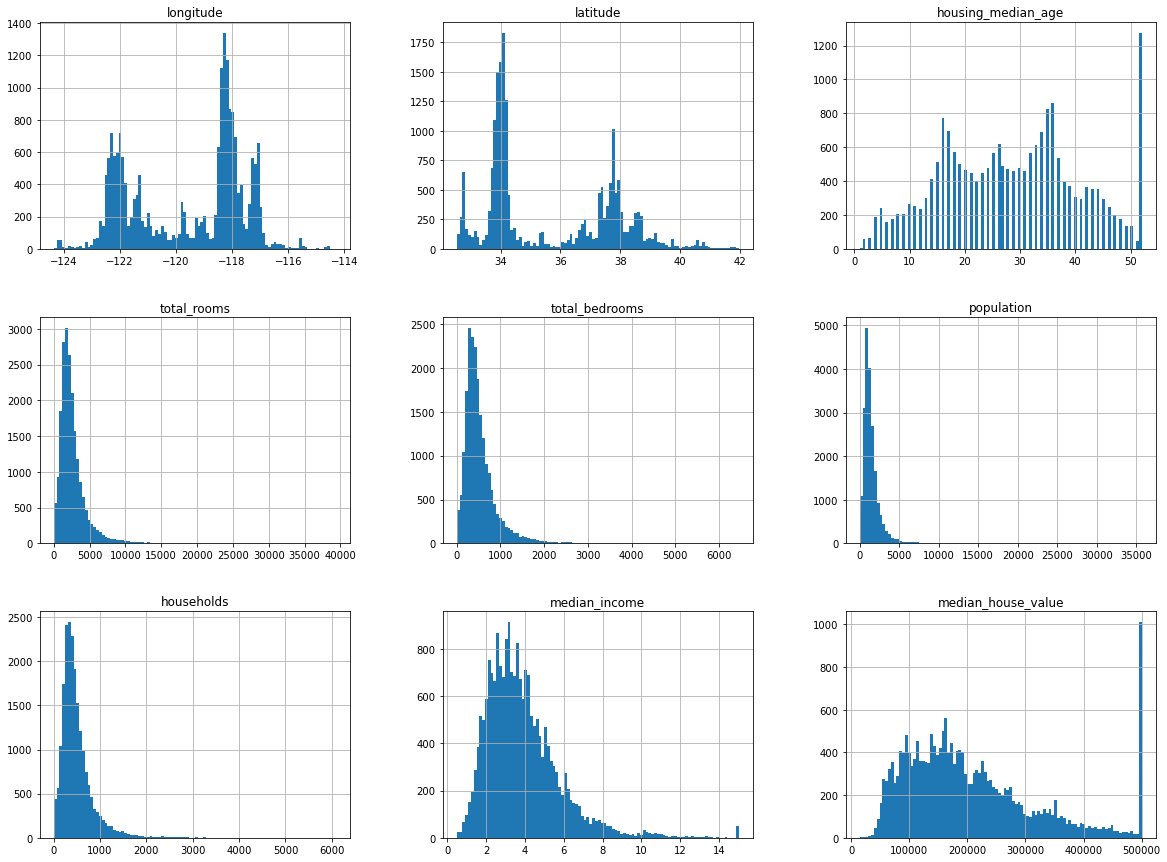

In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt

ho.hist(bins= 100, figsize = (20,15))
plt.show()

# !!!! housing_median_age and median_house_value have been cut!

#### Let's look at the geographical data:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

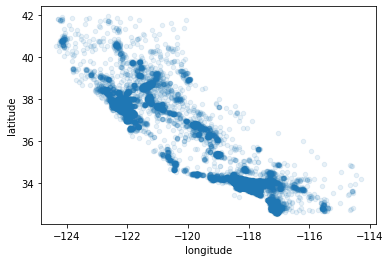

In [15]:
ho.plot(kind='scatter', x='longitude', y='latitude', alpha= 0.1) # the alpha make it easier to see places with high density of points

# ..looks like California!!

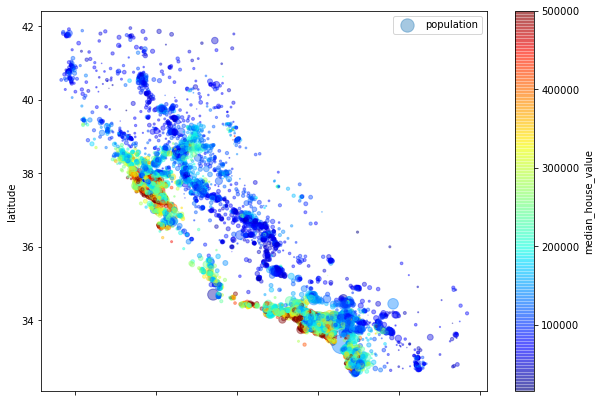

In [16]:
ho.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
       s= ho['population']/100, label= 'population', figsize = (10,7),
       c= 'median_house_value', cmap= plt.get_cmap('jet'), colorbar= True)
plt.legend()

# house prices are very much related to the location

In [32]:
# CODE FOR NICER FIGURE:


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
#print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

import matplotlib.image as mpimg

california_img=mpimg.imread(os.path.join(images_path, filename))

def California(ho, attr):
    ax = ho.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                      s=ho['population']/100, label="Population",
                      c=attr, cmap=plt.get_cmap("jet"),
                      colorbar=False, alpha=0.4)
    plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
               cmap=plt.get_cmap("jet"))
    plt.ylabel("Latitude", fontsize=14)
    plt.xlabel("Longitude", fontsize=14)

    prices = ho[attr]
    tick_values = np.linspace(prices.min(), prices.max(), 11)
    cbar = plt.colorbar(ticks=tick_values/prices.max())
    cbar.ax.set_yticklabels([(round(v/1000)) for v in tick_values], fontsize=14)
    cbar.set_label(attr, fontsize=16)

    plt.legend(fontsize=16)
    #save_fig("california_housing_prices_plot")
    plt.show()

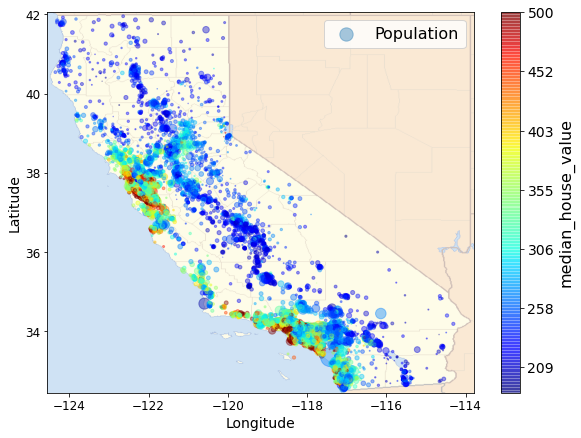

In [33]:
California(ho, 'median_house_value')

### Looking for correlations

In [15]:
corr_matrix= ho.corr()

# lets see how much each attribute correlates with house price
corr_matrix['median_house_value'].sort_values(ascending=False)

# Remark: negative correlation with latitude. Prices go down if I go north!
# and of course also a high correlation with the median_income

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

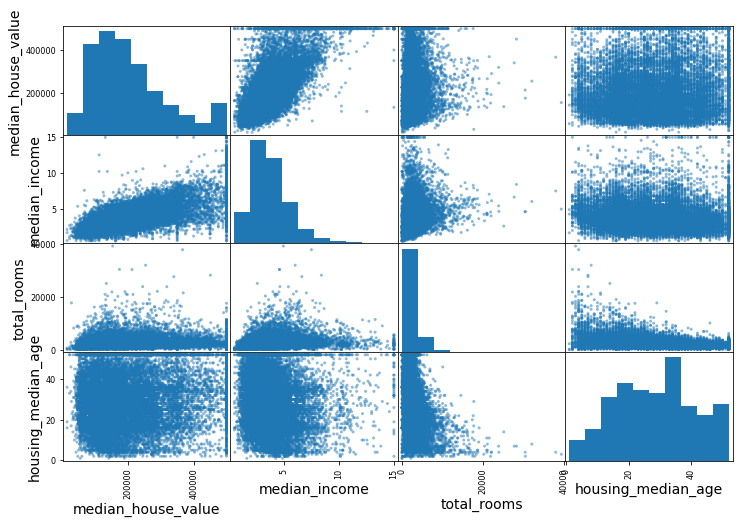

In [16]:
from pandas.plotting import scatter_matrix

# we focus on some promising attributes

attr = ['median_house_value', 'median_income',
       'total_rooms', 'housing_median_age']

scatter_matrix(ho[attr], figsize = (12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

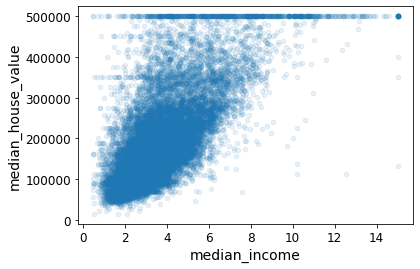

In [17]:
# median_income looks promising. Let's zoom in

ho.plot(kind= 'scatter', x= 'median_income', y='median_house_value', alpha= 0.1)

# !!! all the prices above 500k have ben set to 500001...

array([[<AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

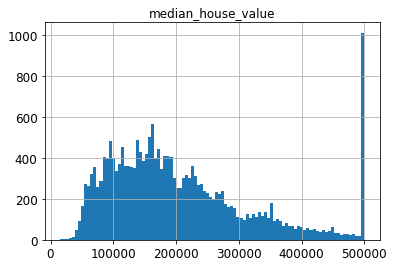

In [94]:
# the fact that all the prices above 500k are cut is a huge problem...
ho.hist(bins = 100, column = 'median_house_value') 

In [82]:
ho[ho['median_house_value']== 500001.0].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,965.000000,965.000000,965.000000,965.000000,958.000000,965.000000,965.000000,965.000000,965.0
mean,-119.702477,35.225751,33.802073,2961.968912,501.782881,1112.808290,465.973057,7.825123,500001.0
std,1.946521,1.783949,13.027787,2162.502126,398.408898,813.321776,361.299205,3.245021,0.0
min,-122.640000,32.680000,2.000000,8.000000,1.000000,13.000000,1.000000,0.499900,500001.0
25%,-122.120000,33.970000,24.000000,1668.000000,266.000000,636.000000,252.000000,5.239100,500001.0
50%,-118.480000,34.130000,34.000000,2518.000000,401.000000,927.000000,374.000000,7.719700,500001.0
75%,-118.330000,37.400000,44.000000,3542.000000,609.500000,1347.000000,574.000000,10.112200,500001.0
max,-116.430000,38.910000,52.000000,18132.000000,5419.000000,7431.000000,4930.000000,15.000100,500001.0


- Of course, the houses with price 500001 correspond to higher median_income.
- we could investigate more about the other variables

In [86]:
ho[ho['median_house_value']!= 500001.0].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,19675.000000,19675.000000,19675.000000,19675.000000,19475.000000,19675.000000,19675.000000,19675.000000,19675.000000
mean,-119.563192,35.651780,28.386277,2619.763659,539.645751,1440.812198,501.186023,3.676717,192477.921017
std,2.006108,2.149802,12.509113,2181.348207,422.413200,1143.648725,383.264636,1.570272,97711.509613
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.760000,33.930000,18.000000,1438.000000,297.000000,796.000000,282.000000,2.526800,116600.000000
50%,-118.500000,34.270000,28.000000,2111.000000,436.000000,1179.000000,411.000000,3.450000,173800.000000
75%,-117.990000,37.730000,37.000000,3120.000000,648.000000,1746.000000,606.000000,4.582600,248200.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500000.000000


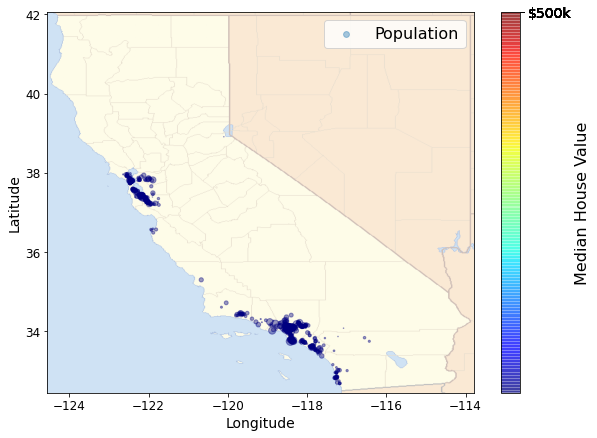

In [27]:
# where are these expensive houses distributed?

expensive_ho = ho[ho['median_house_value']== 500001.0]
California(expensive_ho, 'median_house_value')

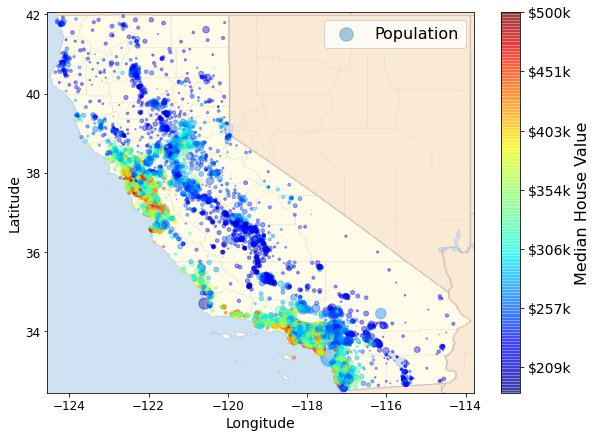

In [28]:
California(ho[ho['median_house_value']!= 500001.0], 'median_house_value')

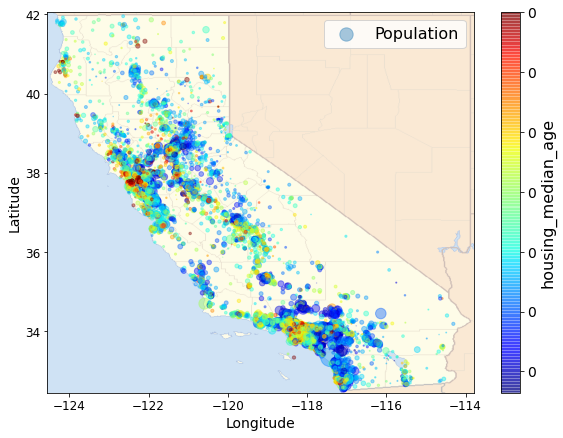

In [34]:
California(ho, 'housing_median_age')

array([[<AxesSubplot:title={'center':'housing_median_age'}>]],
      dtype=object)

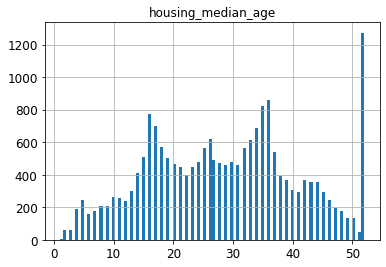

In [101]:
ho.hist(bins = 100, column = 'housing_median_age')
#ho.housing_median_age.value_counts() 
# 52.0    1273
# 36.0     862

#also here there is a big gap between the first and the second

#### How is ocean_proximity relevant?

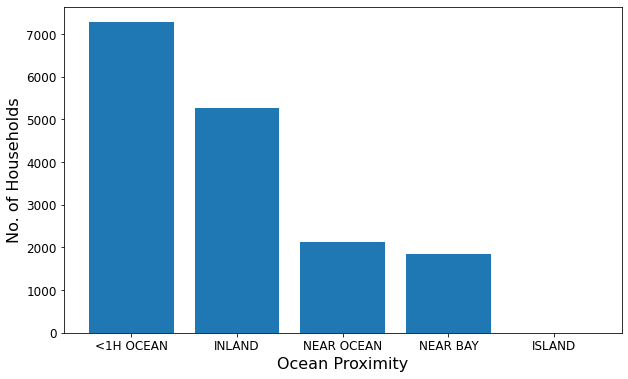

In [37]:
oc = ho.ocean_proximity.value_counts()
plt.figure(figsize=(10, 6))
plt.bar(oc.index, height = oc)#,ec='#21209c',color='#008891')
plt.xlabel('Ocean Proximity', fontsize=16)
plt.ylabel('No. of Households', fontsize=16)
plt.show()

# we'll probably drop island

In [45]:
from sklearn. preprocessing import OneHotEncoder

oc = ho[['ocean_proximity', 'median_house_value']].copy()
ocean = {'<1H OCEAN': 1, 'INLAND': 0, 'NEAR OCEAN': 1, 'NEAR BAY': 1, 'ISLAND': 1}
oc['ocean_proximity'] = oc['ocean_proximity'].map(ocean)
oc.corr()
# -0.259521 selecting only '<1H OCEAN'
# 0.482886 only 'INLAND', pretty high! 
# we'll keep an eye on this during ML

,ocean_proximity,median_house_value
ocean_proximity,1.000000,0.482886
median_house_value,0.482886,1.000000


## Creating new attributes

In [21]:
ho['rooms_per_hausehold'] = ho['total_rooms']/ho['households']
ho['bedrooms_per_room'] = ho['total_bedrooms']/ho['total_rooms']
ho['population_per_household'] = ho['population']/ho['households']

corr_matrix = ho.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_hausehold         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare Data for ML

1) fill nan in total_bedrooms

2) add new attributes

3) bin median_income and housing_median_age

4) encode ocean_proximity

5) Scale the num attributes  (necessary??)

In [111]:
# back to strat_train_set

ho_train = strat_train_set.drop('median_house_value', axis=1) # drop labels for training set
ho_labels = strat_train_set['median_house_value'].copy()

In [23]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

# have to consider only numerical data:
ho_num = ho_train.drop('ocean_proximity', axis=1)
imputer.fit(ho_num)

print('imputer.statistics_:\n',imputer.statistics_,'\n') # all the medians.. same as ho_num.median().values

X = imputer.transform(ho_num)     # fill missing values with median. It is an array!!
ho_tr = pd.DataFrame(X, columns= ho_num.columns, index = ho_num.index)

ho_tr.info()

imputer.statistics_:
 [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [24]:
# Let's deal with categorical attributes:

print('ocean_proximity:\n',ho['ocean_proximity'].value_counts(), '\n')

ho_cat = ho_train[['ocean_proximity']]

from sklearn. preprocessing import OneHotEncoder
hot_enc = OneHotEncoder()
ho_hot_enc = hot_enc.fit_transform(ho_cat)
ho_hot_enc.toarray()   # it is a sparse matrix otherwise

hot_enc.categories_

ocean_proximity:
 <1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64 



[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

# let us create a transformer that adds the new attributes, so that we can use a pipeline

# column index
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [ho.columns.get_loc(c) for c in col_names] # get the column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # BaseEstimator gets the extra methods get_params() and set_params()
    # TransformerMixin gives the fit_transform() method for free
    
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
            # np.c_ translates slice objects to concatenation along the second axis.
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
ho_extra_attribs = attr_adder.transform(ho_train.values)

In [26]:
# ho_extra_attribs is a NumPy array, we've lost the column names. To recover a DataFrame, run this:

ho_extra_attribs = pd.DataFrame(
    ho_extra_attribs,
    columns=list(ho_train.columns)+["rooms_per_household", "population_per_household"],
    index=ho_train.index)
ho_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847


In [112]:
# it's time for a Pipeline!

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer

ho_num = ho_train.drop('ocean_proximity', axis=1)
ho_cat = ho_train[['ocean_proximity']]


num_pipeline= Pipeline([
        ('imputer', SimpleImputer(strategy= 'median')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('bin', KBinsDiscretizer()),
    ])

ho_num_tra = num_pipeline.fit_transform(ho_num)
ho_num_tra

<16512x55 sparse matrix of type '<class 'numpy.float64'>'
	with 181632 stored elements in Compressed Sparse Row format>

In [113]:
# even better, a single transformer for numerical and categorical data:

num_attr = list(ho_num)
cat_attr = ['ocean_proximity']

from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
            ('num', num_pipeline, num_attr), # name, tranformer, list of columns that the trans should be applied to
            ('cat', OneHotEncoder(), cat_attr),
        ])
  
ho_ready = full_pipeline.fit_transform(ho_train)

In [114]:
ho_ready

<16512x60 sparse matrix of type '<class 'numpy.float64'>'
	with 198144 stored elements in Compressed Sparse Row format>

## Select and train the model

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# let's keep this as a function.. we'll need it!
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Scores std: ', scores.std())

#### Linear regression

In [115]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, ho_ready, ho_labels, scoring ='neg_mean_squared_error', cv = 10) # recall cv means it takes 10 subsets
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores:  [67427.14513021 67204.36026157 69187.66803092 70753.33280036
 67861.84423383 71421.86293865 66307.72117173 68794.86750319
 72562.86875582 68597.98058488]
Mean:  69011.96514111552
Scores std:  1900.344040368236


In [32]:
# it can be better to add some parameters...
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_reg = Ridge()

params_Ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
ridge_grid_Search = GridSearchCV(ridge_reg, param_grid=params_Ridge, cv = 5, scoring = 'neg_mean_squared_error', return_train_score=True)

ridge_grid_Search.fit(ho_ready, ho_labels)
ridge_grid_Search.best_params_

# mah... the lin_reg it's better (alpha=0, indeed)!!
# I tried, same story with lasso.

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.39613e-18): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.01548e-17): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.33181e-17): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.41615e-17): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.80607e-17): result may not be accurate.
  overwrite_a=True).T


{'alpha': 0.001, 'fit_intercept': True, 'solver': 'saga'}

In [33]:
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(ho_ready, ho_labels)
ho_lin_pred = lin_reg.predict(ho_ready)
np.sqrt(mean_squared_error(ho_labels, ho_lin_pred))

68628.19819848923

In [34]:
print('coefficients:\n')
for coef, col in zip(lin_reg.coef_, ho.columns):
    print(coef, col)

print('\nintercept:\n', lin_reg.intercept_)

coefficients:

-55650.411640302336 longitude
-56716.45236929204 latitude
13732.838418555379 housing_median_age
-1933.1277138004748 total_rooms
7330.040621029367 total_bedrooms
-45708.2630667283 population
45455.47519691451 households
74714.39134153823 median_income
6605.128028015145 median_house_value
1042.9570945282046 ocean_proximity
9249.758866973702 rooms_per_hausehold
-18016.524321683224 bedrooms_per_room
-55219.15208555363 population_per_household

intercept:
 236914.9973281599


Text(0, 0.5, 'median_house_value')

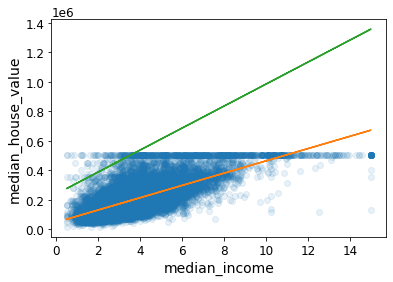

In [48]:
x= ho['median_income']
y=ho_labels #['median_house_value']

plt.plot(x, y, 'o', alpha = 0.1)

m, b = np.polyfit(x, y, 1)

m_1 = lin_reg.coef_[7]
b_1 = lin_reg.intercept_

plt.plot(x, m*x + b)

plt.plot(x, m_1*x + b_1)

plt.xlabel('median_income')
plt.ylabel('median_house_value')

# the linear regressor looks very much wrong.... the problem is the huge amount of houses with 500k value

In [76]:
# let's try to remove them:

full_pipeline_m = ColumnTransformer([
            ('num', num_pipeline, num_attr), # name, tranformer, list of columns that the trans should be applied to
            ('cat', OneHotEncoder(), cat_attr),
        ])

ho_modif = strat_train_set[strat_train_set['median_house_value']!= 500001.0]
print('I loose ' , len(strat_train_set)-len(ho_modif), ' train entries out of ', len(ho))

ho_labels_modif = ho_modif['median_house_value']
ho_train_modif = ho_modif.drop(['median_house_value'], axis = 1)

ho_ready_modif = full_pipeline_m.fit_transform(ho_train_modif)

I loose  786  train entries out of  16512


In [44]:
lin_reg_modif = LinearRegression()
lin_reg_modif.fit(ho_ready_modif, ho_labels_modif)
ho_lin_pred_modif = lin_reg_modif.predict(ho_ready_modif)
np.sqrt(mean_squared_error(ho_labels_modif, ho_lin_pred_modif))

60759.7591027173

74714.39134153823 60512.34715222468
236914.9973281599 225007.164526397


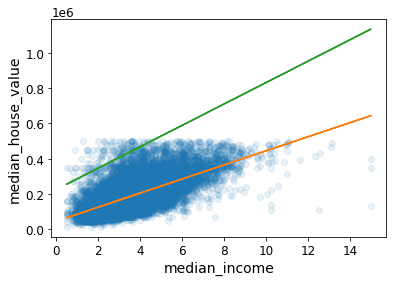

In [49]:
x= ho_modif['median_income']
y=ho_labels_modif #['median_house_value']

plt.plot(x, y, 'o', alpha = 0.1)

m, b = np.polyfit(x, y, 1)

m_2 = lin_reg_modif.coef_[7]
b_2 = lin_reg_modif.intercept_

plt.plot(x, m*x + b)

plt.plot(x, m_2*x + b_2)

plt.xlabel('median_income')
plt.ylabel('median_house_value')

print(m_1, m_2)
print(b_1, b_2)

#### Trees and forests

In [116]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(ho_ready, ho_labels)


scores = cross_val_score(tree_reg, ho_ready, ho_labels, scoring ='neg_mean_squared_error', cv = 10) # recall cv means it takes 10 subsets
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

# Mean:  70687.34927001962
#Scores std:  2576.2499078633823

Scores:  [83480.22782377 81765.8794902  82113.79618534 80607.2044923
 79680.21573789 86499.11461177 81395.93607801 79668.96798361
 90012.31526748 83350.05923403]
Mean:  82857.37169044014
Scores std:  3070.663515307083


In [35]:
# Gridsearch for best parameters:

from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators' : [30, 50, 100], 'max_features': [8, 10, 13]},    # first evaluate these 12 combinations
    #{'bootstrap': [False], 'n_estimators' : [3,10], 'max_features': [2,3,4]}    # and after try the 6 combinations with bootstrap False
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score=True)

grid_search.fit(ho_ready,ho_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [8, 10, 13],
                          'n_estimators': [30, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [36]:
grid_search.best_params_ # gives {'max_features': 8, 'n_estimators': 30}.
# as they are the max values I'll try again with higher parameters---> gives 8, 100

{'max_features': 8, 'n_estimators': 100}

In [37]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50922.35749553866 {'max_features': 8, 'n_estimators': 30}
50332.95244867649 {'max_features': 8, 'n_estimators': 50}
50069.8969334536 {'max_features': 8, 'n_estimators': 100}
50718.68454860501 {'max_features': 10, 'n_estimators': 30}
50424.71449034609 {'max_features': 10, 'n_estimators': 50}
50108.10199158927 {'max_features': 10, 'n_estimators': 100}
50892.75291095464 {'max_features': 13, 'n_estimators': 30}
50707.54735636824 {'max_features': 13, 'n_estimators': 50}
50122.51519605868 {'max_features': 13, 'n_estimators': 100}


In [38]:
forest_reg = RandomForestRegressor(max_features = 8, n_estimators=100)

scores = cross_val_score(forest_reg, ho_ready, ho_labels, scoring ='neg_mean_squared_error', cv = 10) # recall cv means it takes 10 subsets
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

Scores:  [48839.32027558 47227.58788509 49541.04987572 51292.388549
 49039.55593103 53463.86046851 48120.71828782 47941.81239207
 52499.95484156 49545.38426678]
Mean:  49751.163277316635
Scores std:  1934.94755492122


#### We try to make an Ensemble from the best estimators

In [51]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(max_features = 8, n_estimators=100)



In [40]:
from sklearn.ensemble import VotingRegressor


voting = VotingRegressor(estimators=[('lr', lin_reg),('forest', forest_reg)])
voting.fit(ho_ready,ho_labels)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('forest', RandomForestRegressor(max_features=8))])

In [41]:
scores = cross_val_score(voting, ho_ready, ho_labels, scoring ='neg_mean_squared_error', cv = 10) # recall cv means it takes 10 subsets
popular_rmse_scores = np.sqrt(-scores)

display_scores(popular_rmse_scores)

Scores:  [54836.65520817 53284.65912939 56374.06555242 59108.1522922
 55030.59509471 59009.57718779 52905.70778311 54255.24152607
 58488.00387756 55783.56369038]
Mean:  55907.62213417897
Scores std:  2174.7363358044763


In [42]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(forest_reg)
bag_clf.fit(ho_ready, ho_labels)

bag_rmse_scores = np.sqrt(-scores)

display_scores(bag_rmse_scores)

# è uguale!!


Scores:  [54836.65520817 53284.65912939 56374.06555242 59108.1522922
 55030.59509471 59009.57718779 52905.70778311 54255.24152607
 58488.00387756 55783.56369038]
Mean:  55907.62213417897
Scores std:  2174.7363358044763


### feature importance

In [43]:
forest_reg.fit(ho_ready, ho_labels)

feat = forest_reg.feature_importances_

feat

array([6.23682099e-02, 5.63815971e-02, 4.58063416e-02, 1.60031066e-02,
       1.62806006e-02, 1.54812737e-02, 1.56863403e-02, 3.05550835e-01,
       1.38766540e-01, 3.53806507e-02, 1.10019532e-01, 3.94511246e-02,
       6.56603153e-03, 1.29529439e-01, 1.04343258e-04, 2.76857987e-03,
       3.85545438e-03])

In [44]:
extra_attr = ['rooms per hhold','pop per hhold', 'bedrooms per hhold']
cat_encoder= full_pipeline.named_transformers_['cat']
cat_one_hot_attr = list(cat_encoder.categories_[0])
attrib = num_attr + extra_attr + cat_one_hot_attr
sorted(zip(feat, attrib), reverse = True)

[(0.30555083451100756, 'median_income'),
 (0.13876653975896616, 'income_cat'),
 (0.12952943924281812, 'INLAND'),
 (0.11001953244961912, 'pop per hhold'),
 (0.062368209888840946, 'longitude'),
 (0.05638159708375611, 'latitude'),
 (0.045806341595213886, 'housing_median_age'),
 (0.039451124626574866, 'bedrooms per hhold'),
 (0.03538065065819449, 'rooms per hhold'),
 (0.016280600593201387, 'total_bedrooms'),
 (0.01600310658080382, 'total_rooms'),
 (0.01568634029384424, 'households'),
 (0.0154812736850136, 'population'),
 (0.0065660315251866155, '<1H OCEAN'),
 (0.003855454380758773, 'NEAR OCEAN'),
 (0.0027685798681435286, 'NEAR BAY'),
 (0.0001043432580567655, 'ISLAND')]

#### create new pipeline that selects most important features
For example, among the ocean_proximity, only INLAND is relevant

In [68]:
# create a new transformer that selects only INLAND, and encodes it too

class AttributeSelector(BaseEstimator, TransformerMixin):
    # BaseEstimator gets the extra methods get_params() and set_params()
    # TransformerMixin gives the fit_transform() method for free
    
    def __init__(self): # no *args or **kargs
        print('')
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        # non inlansds to 0
        non_inland_ind = X.loc[X['ocean_proximity'] != 'INLAND'].index
        X.loc[non_inland_ind,'ocean_proximity'] = np.zeros(len(non_inland_ind))
        # inland to 1
        inland_ind = X.loc[X['ocean_proximity'] == 'INLAND'].index
        X.loc[inland_ind,'ocean_proximity'] = np.ones(len(inland_ind))
        
        return X

In [69]:
ho = strat_train_set.drop('median_house_value', axis=1) # drop labels for training set
ho_labels = strat_train_set['median_house_value'].copy()

ho_num = ho.drop('ocean_proximity', axis=1)

num_pipeline= Pipeline([
        ('imputer', SimpleImputer(strategy= 'median')), # fill nan
        ('attribs_adder', CombinedAttributesAdder()),   # adds 3 new cols
        ('std_scaler', StandardScaler()),               # scaler
    ])

full_pipeline_for_real = ColumnTransformer([
            ('sel',AttributeSelector(),['ocean_proximity']),  # selects only inland
            ('num', num_pipeline, num_attr), # name, tranformer, list of columns that the trans should be applied to
        ])


ho_ready_for_real = full_pipeline_for_real.fit_transform(ho)


pd.DataFrame(
    ho_ready_for_real,
    #columns=list(ho.columns),
    index=ho.index)

In [48]:
# let's try again the classifier

forest_reg = RandomForestRegressor(max_features = 8, n_estimators=100)

scores = cross_val_score(forest_reg, ho_ready_for_real, ho_labels, scoring ='neg_mean_squared_error', cv = 10) # recall cv means it takes 10 subsets
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

# was better before -.-

Scores:  [49132.24277673 47711.60049922 49188.16468597 51569.86327227
 49118.57770171 53087.1071695  48400.19591579 47932.42876635
 52800.34528684 50054.35433507]
Mean:  49899.48804094497
Scores std:  1843.8693983714334


In [56]:
# try with the modified training set, i.e., without the 500k values

forest_reg_modif = RandomForestRegressor(max_features = 8, n_estimators=100)

scores_modif = cross_val_score(forest_reg_modif,ho_ready_modif, ho_labels_modif , scoring ='neg_mean_squared_error', cv = 10) # recall cv means it takes 10 subsets
forest_rmse_scores_modif = np.sqrt(-scores_modif)

display_scores(forest_rmse_scores_modif)

# better!! :)


Scores:  [43816.15320385 43455.80784706 45980.92536792 46407.68372555
 44569.85055656 46578.1496142  44075.67062039 43572.82308844
 46131.68843105 44004.9289603 ]
Mean:  44859.368141532075
Scores std:  1198.7379221837502


In [63]:
param_grid = [
    {'n_estimators' : [150, 200, 300], 
     'max_features': [3, 5, 8]
    },    # first evaluate these 12 combinations
    #{'bootstrap': [False], 'n_estimators' : [3,10], 'max_features': [2,3,4]}    # and after try the 6 combinations with bootstrap False
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score=True)

grid_search.fit(ho_ready_modif, ho_labels_modif)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [3, 5, 8],
                          'n_estimators': [150, 200, 300]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [64]:
grid_search.best_params_ 

{'max_features': 8, 'n_estimators': 300}

In [65]:
scores_gs_modif = cross_val_score(grid_search.best_estimator_,ho_ready_modif, ho_labels_modif , scoring ='neg_mean_squared_error', cv = 10) # recall cv means it takes 10 subsets
forest_rmse_gs_modif = np.sqrt(-scores_gs_modif)

display_scores(forest_rmse_gs_modif)

# better but overfits!!


Scores:  [43649.73683014 42580.86738357 45860.85320687 45986.29718263
 44663.92962551 46304.62508649 43777.89118564 43401.26013102
 45745.12094979 43717.46848364]
Mean:  44568.805006530456
Scores std:  1248.7823570204769


### Gradient boosting regressor

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor()
gb_reg.fit(ho_ready, ho_labels)

gb_reg_rmse_scores = np.sqrt(-scores)

display_scores(gb_reg_rmse_scores)




Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Scores std:  2731.674001798342


### Time to make a decision!

In [77]:


final_model = RandomForestRegressor(max_features = 8, n_estimators=300).fit(ho_ready_modif, ho_labels_modif)
# (ho_ready_for_real, ho_labels)

X_test = strat_test_set.drop('median_house_value', axis =1)
y_test = strat_test_set['median_house_value'].copy()

X_test_ready = full_pipeline_m.transform(X_test)
final_predictions= final_model.predict(X_test_ready)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

# 47988.507511178184 without _modif

49584.31068219463

In [73]:
# compute a 95% confidence interval for the error:

from scipy import stats
confidence = 0.95

squared_errors= (final_predictions- y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc= squared_errors.mean(),
                        scale= stats.sem(squared_errors)))

array([47659.7778697 , 51672.26726511])